In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
import importlib as il
import datetime as dt

from utility_programs import filters
from scipy.signal import find_peaks
from multiprocessing import Pool, cpu_count


In [2]:
path = '/home/pxv220016/prasoon/data/sat_interp_repo/repo2/Cesar_data/'


date = ['20130316', '20130317', '20130318']
data = []

for d in date:
    p = path + 'file' + d + '.dTEC'
    df = df = pd.read_csv(p, delim_whitespace=True, skiprows=1)
    lat1 = []
    lat2 = []
    lon1 = []
    lon2 = []
    dtec = []
    ds = xr.Dataset.from_dataframe(df)
    print(ds)
    data.append(ds)

<xarray.Dataset>
Dimensions:  (index: 86131)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 86125 86126 86127 86128 86129 86130
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75420 75600 75780 75960 76140
    lon2     (index) int64 360 540 720 900 1080 ... 75960 76140 76320 76500
    dtec     (index) int64 23 28 80 28 25 25 11 7 4 ... 79 80 30 80 81 82 81 81
<xarray.Dataset>
Dimensions:  (index: 103063)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 ... 103058 103059 103060 103061 103062
Data variables:
    lat1     (index) float64 -80.0 -80.0 -80.0 -80.0 ... 62.0 62.0 62.0 62.0
    lat2     (index) float64 -79.5 -79.5 -79.5 -79.5 ... 62.5 62.5 62.5 62.5
    lon1     (index) int64 0 180 360 540 720 ... 75240 75420 75600 75780 75960
    lon2     (index) int64 360 540 720 900 1080 ... 75780 75960 76140 

In [3]:
dates = ['2011-08-06']

for d in dates:
    p = path + d + '.csv'
    df = pd.read_csv(p)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace = True)
    ds = df.to_xarray()
    print(ds)


<xarray.Dataset>
Dimensions:   (Datetime: 252357)
Coordinates:
  * Datetime  (Datetime) datetime64[ns] 2011-08-05 ... 2011-08-07T23:57:00
Data variables:
    Glat      (Datetime) float64 -44.0 23.5 -29.0 -2.0 ... -25.5 -54.0 -5.5 17.5
    dTEC      (Datetime) float64 -0.3556 -0.3778 -0.4222 ... -0.3778 -0.3333


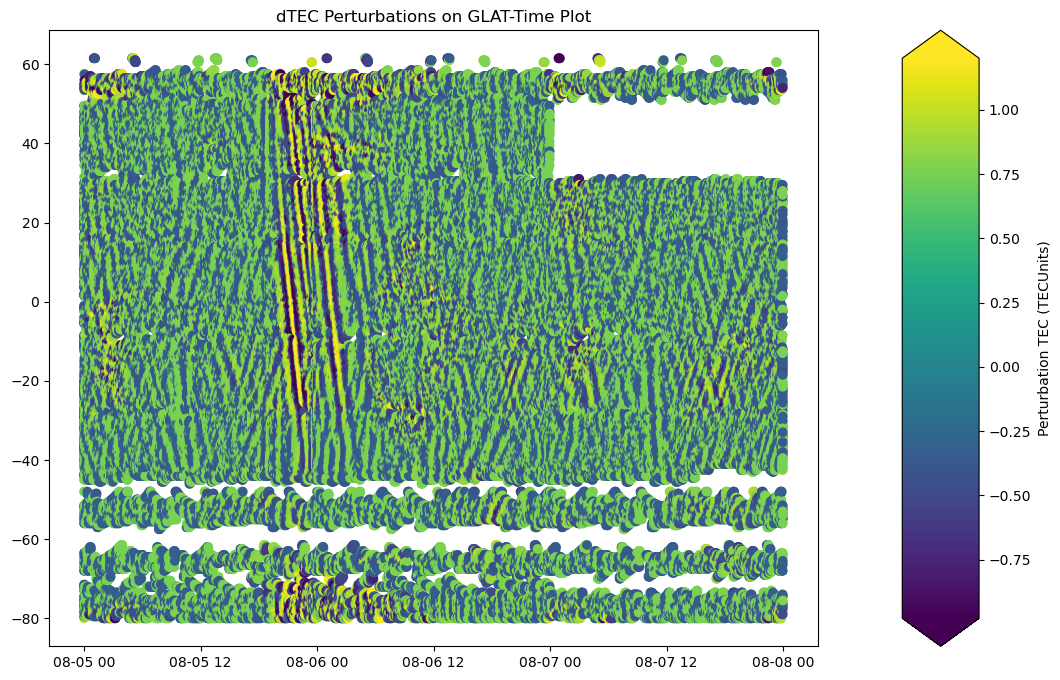

In [5]:
fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
c = ax[0].scatter(ds.Datetime.values, ds.Glat.values, c=ds.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

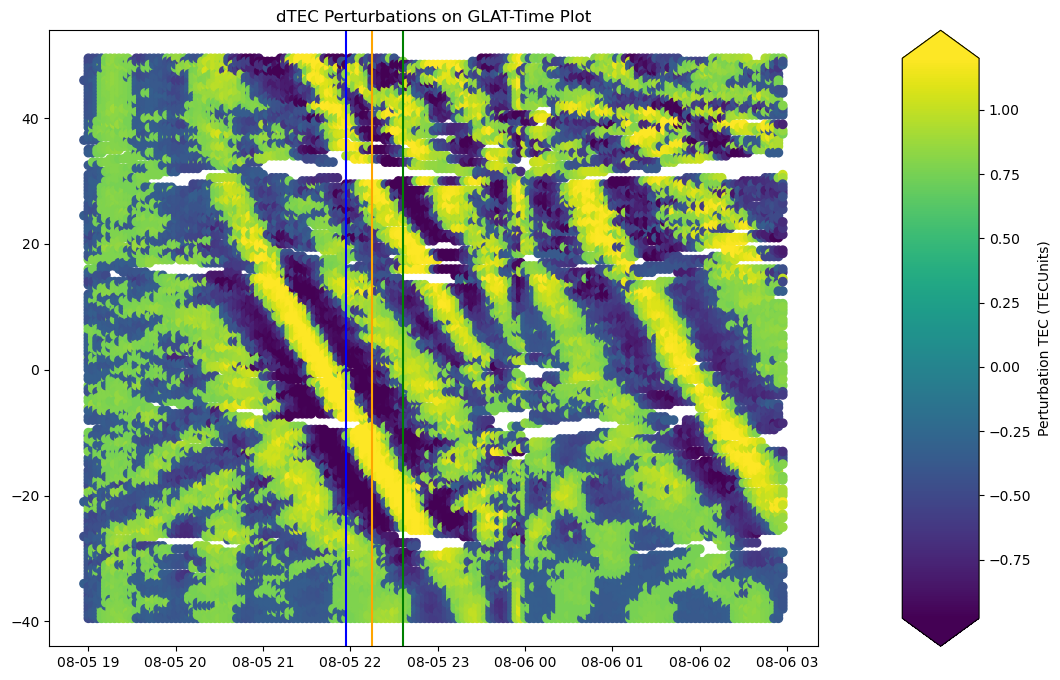

In [55]:
a = 70000
b = 100000

ds_n = ds.isel(Datetime=slice(a,b))

ds_n = ds_n.where((ds_n.Glat > -40), drop=True)
ds_n = ds_n.where((ds_n.Glat < 50), drop=True)

#mask = [(i > -40 and i < 50) for i in ds_n.Glat.values]

fig = plt.figure(figsize=(12,8))
specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
ax = []
ax.append(fig.add_subplot(specs[0, 0]))
ax[0].axvline(x=ds_n.Datetime.values[9000], color='blue')
ax[0].axvline(x=ds_n.Datetime.values[10000], color='orange')
ax[0].axvline(x=ds_n.Datetime.values[11000], color='green')
c = ax[0].scatter(ds_n.Datetime.values, ds_n.Glat.values, c=ds_n.dTEC.values)
ax[0].set_title('dTEC Perturbations on GLAT-Time Plot')

cbar_ax = fig.add_subplot(specs[0,1])
cbar = fig.colorbar(c, cax=cbar_ax, label='Perturbation TEC (TECUnits)', extend='both')
fig.show()

23329 161
2011-08-05T21:57:00.000000000 2011-08-05T22:15:00.000000000 2011-08-05T22:36:00.000000000


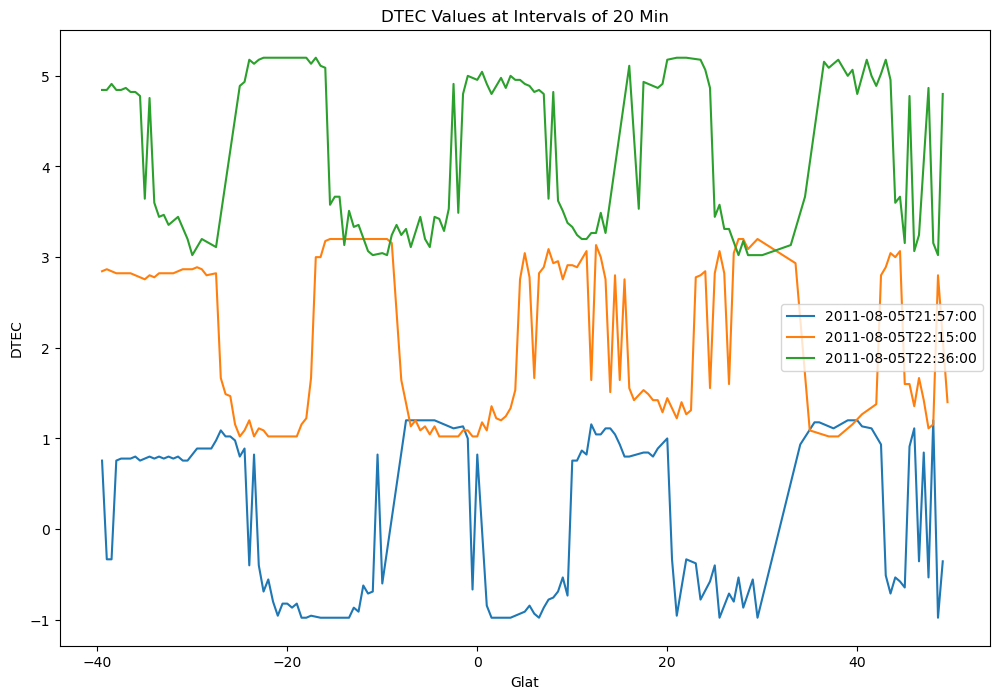

In [5]:
print(len(ds_n.Glat.values), len(np.unique(ds_n.Datetime.values)))

d = ds_n.Datetime.values[9000]
e = ds_n.Datetime.values[10000]
f = ds_n.Datetime.values[11000]
print(d,e,f)

df = ds_n.to_pandas()
df1 = (df.iloc[np.where((ds_n.Datetime == d))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df2 = (df.iloc[np.where((ds_n.Datetime == e))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)
df3 = (df.iloc[np.where((ds_n.Datetime == f))].reset_index(drop=True)).sort_values('Glat', ignore_index=True)


plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('DTEC Values at Intervals of 20 Min')
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()

In [42]:
def correlation(df1, df2):
    corr1 = []
    for i in range(len(df2)-10):
        l1 = len(df2)-10
        n = 0
        d1 = 0
        d2 = 0
        u1 = np.sum(df1[i:l1])/(l1-i)
        u2 = np.sum(df2[:l1-i])/(l1-i)
        
        for j,k in zip(df1[i:l1], df2[:l1-i]):
            n += (j-u1)*(k-u2)
            d1 += (j-u1)**2
            d2 += (k-u2)**2
        c = n/(np.sqrt(d1*d2))
        corr1.append(c)
    
    return corr1

/tmp/ipykernel_44889/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


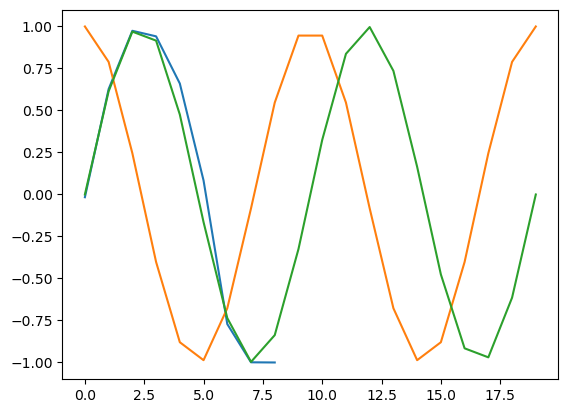

In [47]:
import math

in_array = np.linspace(-(2 * np.pi), 2 * np.pi, 20) 
  
cos = [] 
sin = []
for i in range(len(in_array)): 
    cos.append(math.cos(in_array[i])) 
    sin.append(math.sin(in_array[i]))
    i += 1
c = correlation(sin, cos)
plt.plot(c)
plt.plot(cos)
plt.plot(sin)


Shift 1 = 2.5 glats, Shift 2 = 15.5 glats
slope 1 = 0.1388888888888889 (glat/min), Slope 2 = 0.3974358974358974 (glat/min)


/tmp/ipykernel_44889/3761207125.py:15: RuntimeWarning: invalid value encountered in scalar divide
  c = n/(np.sqrt(d1*d2))


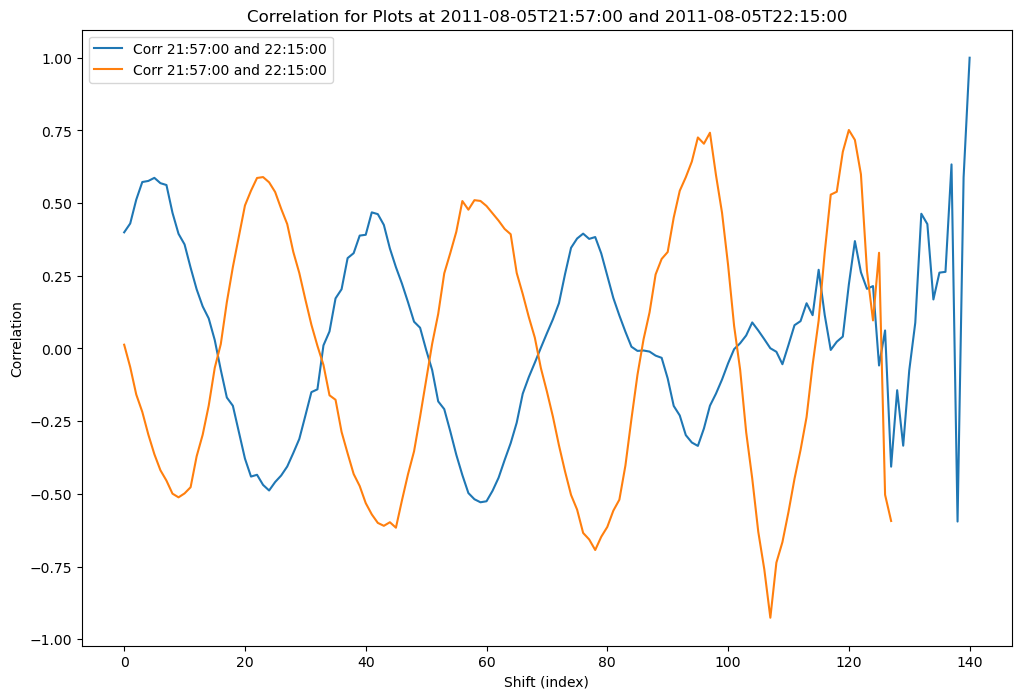

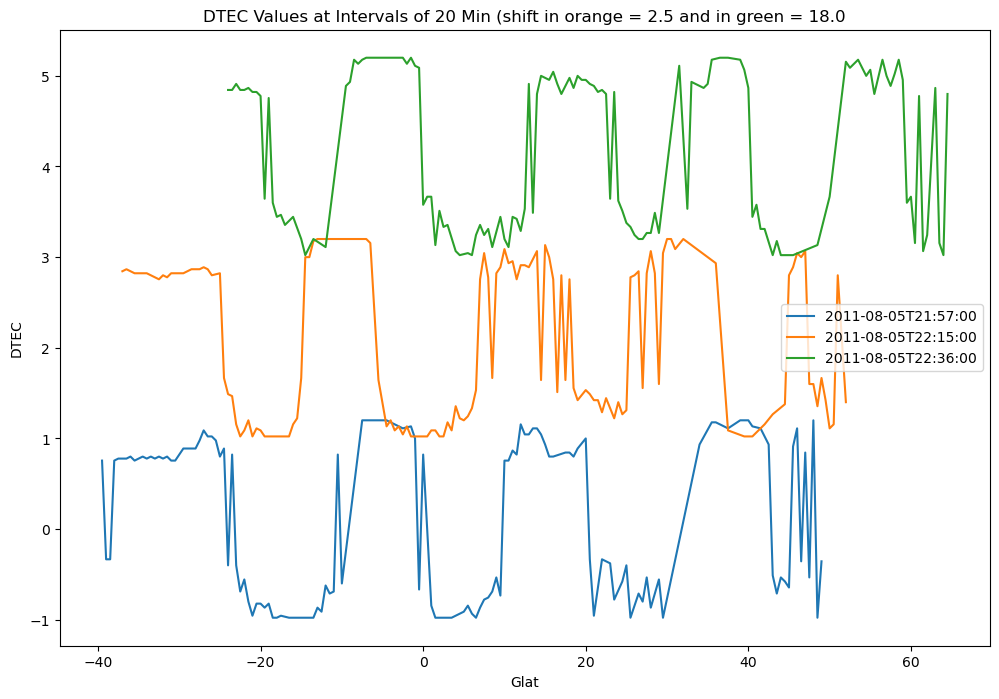

In [56]:
corr1 = correlation(df1.dTEC, df2.dTEC)
corr2 = correlation(df1.dTEC, df3.dTEC)

plt.figure(figsize=(12,8))
plt.plot(corr1, label = 'Corr 21:57:00 and 22:15:00')
plt.plot(corr2, label = 'Corr 21:57:00 and 22:15:00')
plt.ylabel('Correlation')
plt.xlabel('Shift (index)')
plt.title('Correlation for Plots at ' + str(d)[:-10] + ' and ' + str(e)[:-10])
plt.legend()

m1 = max(corr1[:50])
m2 = max(corr2[:50])
s1 = df2.Glat[corr1.index(m1)] - df2.Glat[0]
s2 = df3.Glat[corr2.index(m2)] - df3.Glat[0]


print('Shift 1 =', s1, 'glats, Shift 2 =', s2, 'glats')
t1 = int(e-d)/(60*10**9)
slope1 = s1/t1

t2 = int(f-d)/(60*10**9)
slope2 = s2/t2
print('slope 1 =', slope1, '(glat/min), Slope 2 =', slope2, '(glat/min)')

plt.figure(figsize=(12,8))
plt.plot(df1.Glat.values, df1.dTEC.values, label = str(d)[:-10])
plt.plot(df2.Glat.values + s1, df2.dTEC.values+2, label = str(e)[:-10])
plt.plot(df3.Glat.values + s2, df3.dTEC.values+4, label = str(f)[:-10])
plt.title('DTEC Values at Intervals of 20 Min (shift in orange = ' + str(s1) + ' and in green = ' + str(s2 + s1))
plt.xlabel('Glat')
plt.ylabel('DTEC')
plt.legend()